In [1]:
%reload_ext autoreload
%autoreload 2

In [3]:
import os
import random
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append("../../")

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

from MAPIE.mapie.classification import MapieClassifier
from MAPIE.mapie.metrics import classification_coverage_score, classification_ssc

# Global variables

In [4]:
PATH_PICKLES = "../../pickle_files"
PATH_IMAGES = "../../"
MLP_MODEL_SCORE = "../../model_weights/mlp_score.pt"
MLP_MODEL_APS = "../../model_weights/mlp_aps.pt"

EMBEDDINGS_FILE = "embeddings.pickle"
SOFTMAX_FILE = "score_softmax.pickle"

RADOM_STATE = 42

MODEL = "resnet152"

# Get labels and data

In [5]:
def get_labels(path_labels):
    with open(path_labels, 'r') as f:
        content = f.read()

    content = content.split('\n')

    labels = {}
    for l in content :
        labels[l[:9]] = l[9:]

    return labels # [:-1]

labels = get_labels("../../LOC_synset_mapping.txt")

In [6]:
with open(os.path.join(PATH_PICKLES, EMBEDDINGS_FILE), "rb") as f:
    file = pickle.load(f)
    embeddings = file[MODEL]
    image_names = file["image_file"]
with open(os.path.join(PATH_PICKLES, SOFTMAX_FILE), "rb") as f:
    softmax = pickle.load(f)[MODEL]

In [7]:
softmax_list = [arr for arr in softmax]
X_df = pd.DataFrame({"files_name": image_names, "softmax": softmax_list})

In [8]:
labels_keys = list(labels.keys())

In [9]:
y = [labels_keys.index(image_name.split('/')[2]) for image_name in image_names]

# Plot images for sanity check

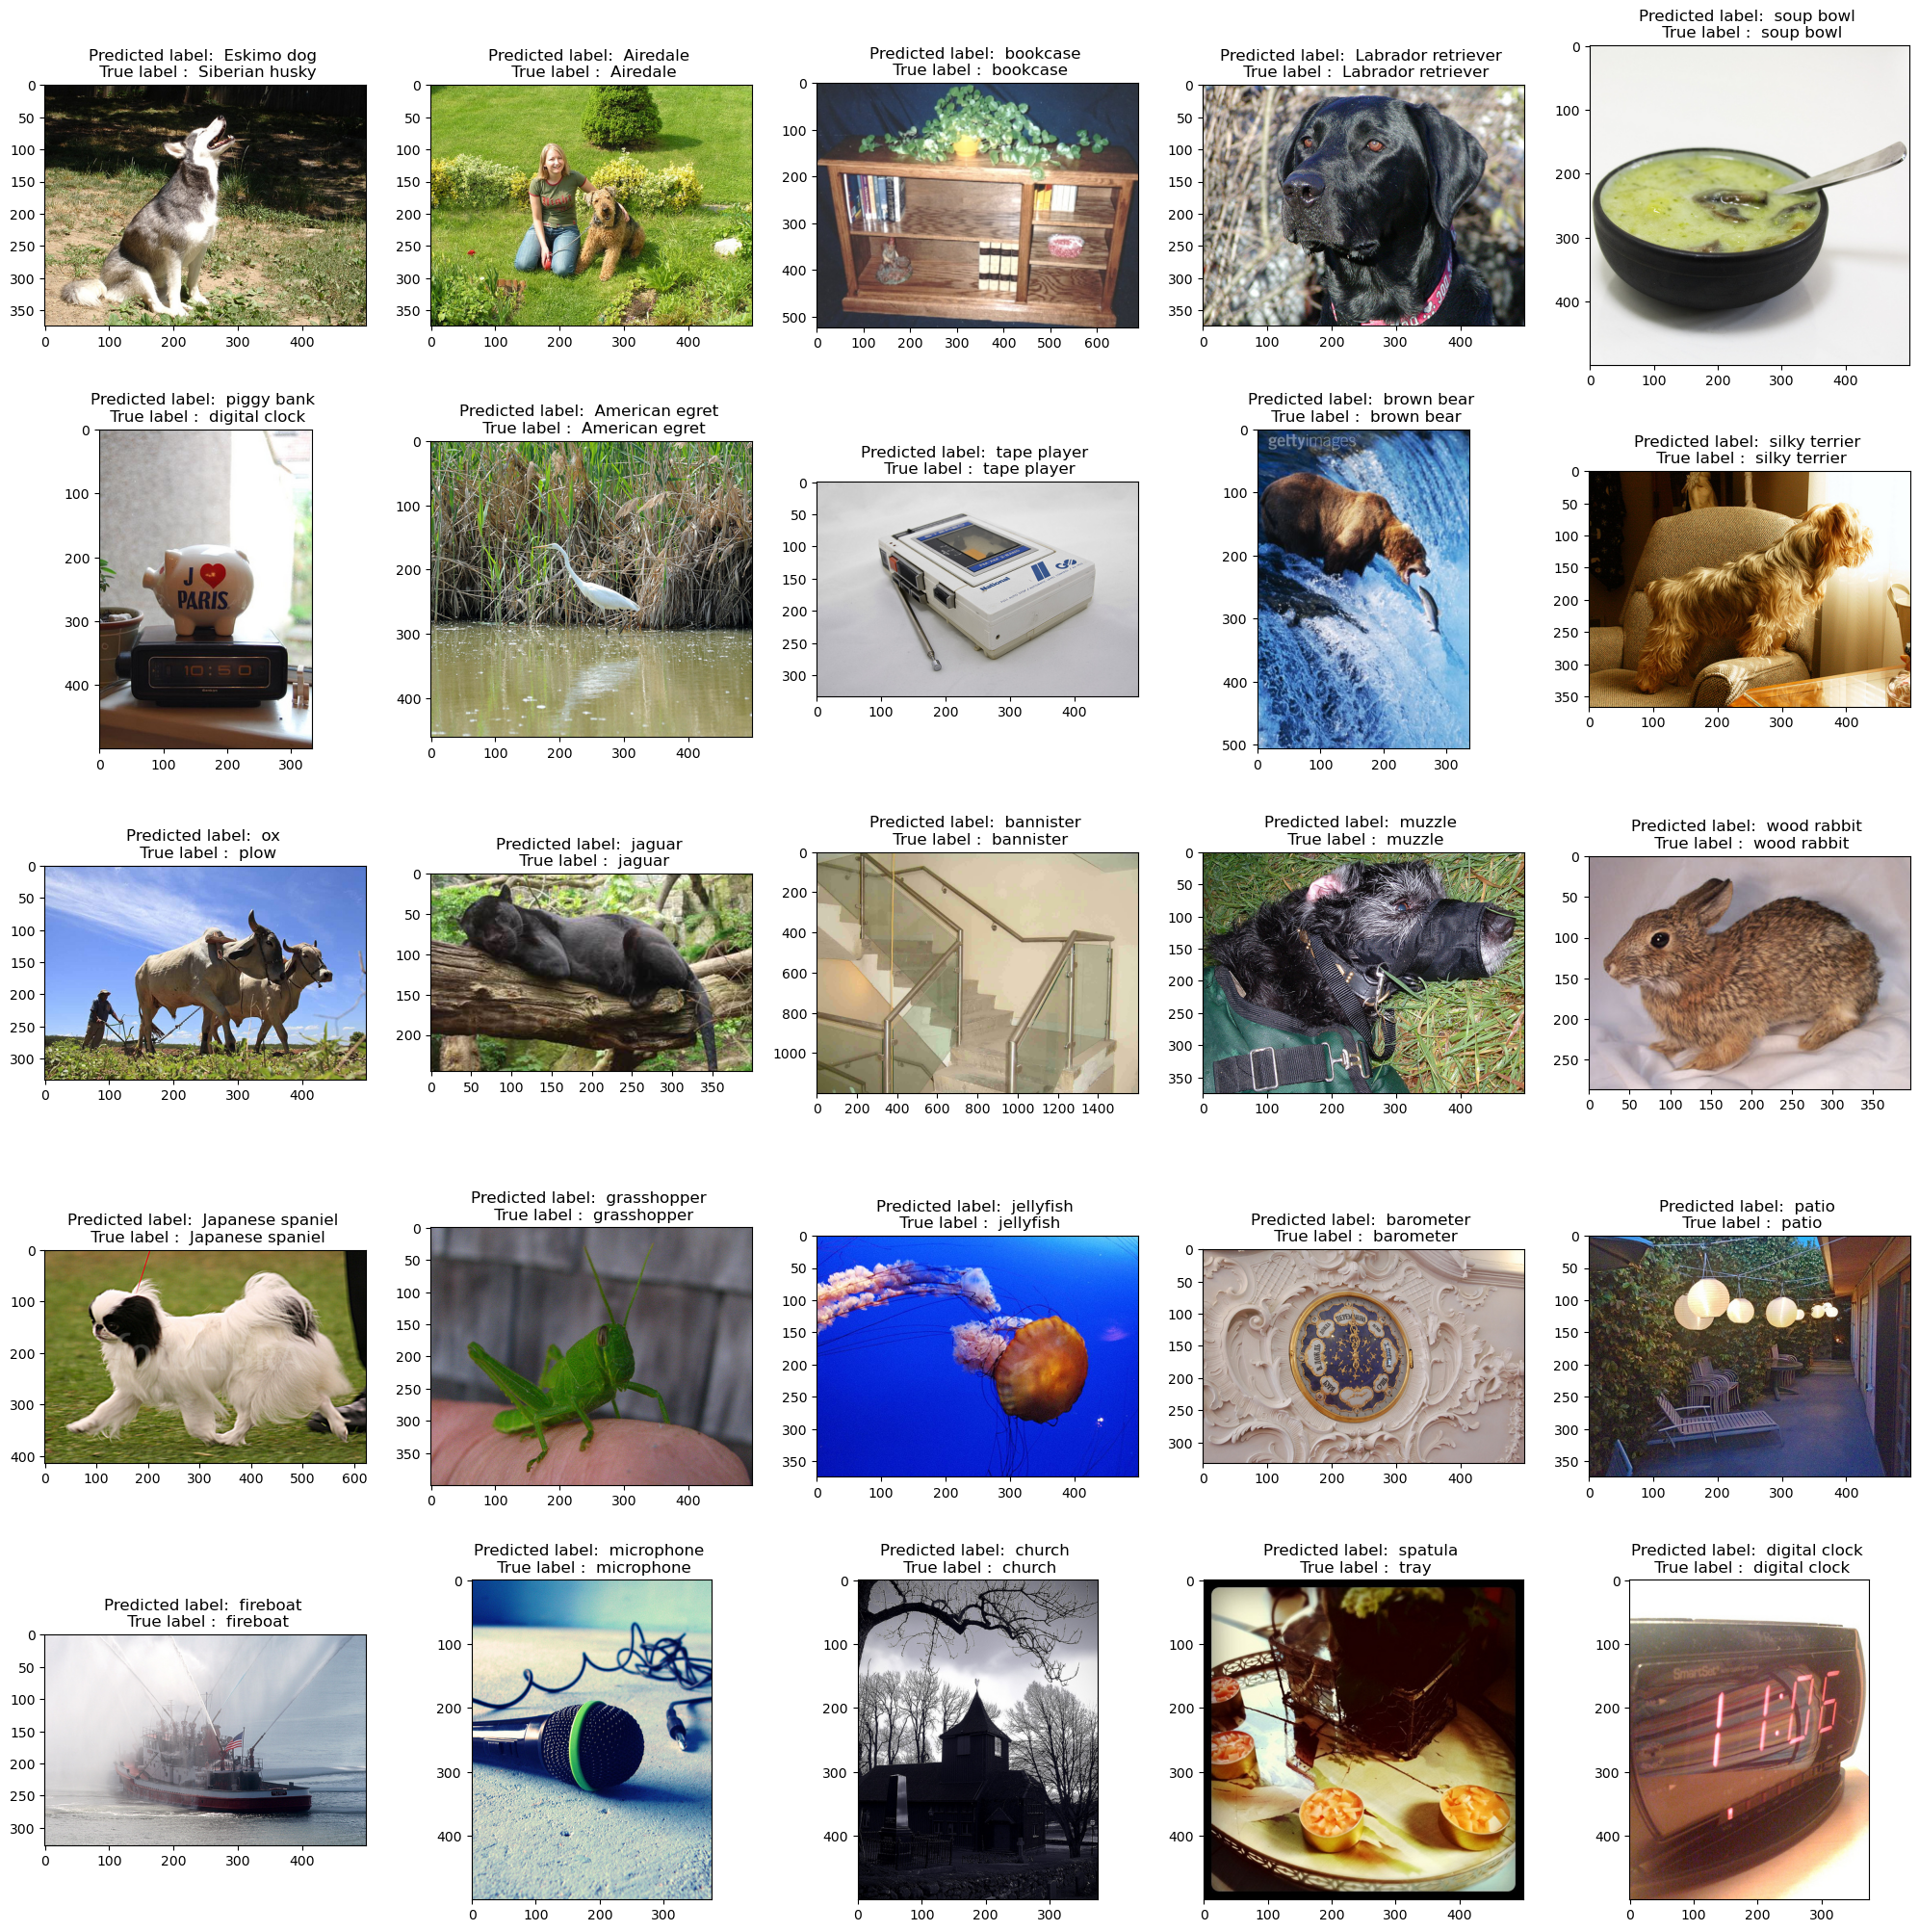

In [10]:
n_rows = 5
n_cols = 5
plot_size = 5

indices_to_plot = random.sample(range(len(image_names)), k=n_rows * n_cols)

f, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * plot_size, n_rows * plot_size))

count = 0
for i in range(n_rows):
    for j in range(n_cols):
        image_index = indices_to_plot[count]
        image_name = X_df.files_name[image_index]
        image = cv2.imread(
            os.path.join(
                PATH_IMAGES,
                image_name
            )
        )
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = labels[image_name.split('/')[2]]

        ax[i, j].imshow(image)
        predicted_label_index = np.argmax(X_df.softmax[image_index])
        predicted_label_key = labels_keys[predicted_label_index]
        predicted_label = labels[predicted_label_key]
        title = f"Predicted label: {predicted_label.split(',')[0]} \n True label : {label.split(',')[0]}"
        ax[i, j].set_title(title)
        count += 1 


# Check Global accuracy

In [11]:
y_preds = np.argmax(np.vstack(X_df['softmax'].values), axis=1)
global_accuracy_score = accuracy_score(y_true=y, y_pred=y_preds)
print(f'Global accuracy score of the model : {global_accuracy_score:.3f}')

Global accuracy score of the model : 0.823


# Define wrapper class for MAPIE

In [12]:
class MapieWrapper():
    def __init__(self):
        self.trained_ = True
        self.classes_ = np.arange(1000)

    def fit(self, X, y=None):
        pass

    def predict_proba(self, X):
        return X

    def predict(self, X):
        pred_proba = self.predict_proba(X)
        pred = np.argmax(pred_proba, axis=1)
        return pred

    def __sklearn_is_fitted__(self):
        return True

# Define residual regressor

In [13]:
class MLP(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer1 = nn.Linear(2048, 1024)
        self.layer2 = nn.Linear(1024, 512)
        self.layer3 = nn.Linear(512, 256)
        self.layer4 = nn.Linear(256, 64)
        self.layer5 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, X):
        out = self.relu(self.layer1(X))
        out = self.relu(self.layer2(out))
        out = self.relu(self.layer3(out))
        out = self.relu(self.layer4(out))
        out = self.relu(self.layer5(out))
        return out

In [38]:
def train_mlp(
        model, X, y,
        optimizer, criterion, n_epochs, patience=5,
        device=torch.device("mps")
):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=RADOM_STATE)
    model.to(device)
    best_val_loss = np.inf
    for epoch in range(n_epochs):
        X_train = torch.Tensor(X_train).to(device)
        y_train = torch.Tensor(y_train).to(device)

        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            val_outputs = model(torch.tensor(X_val).to(device))
            val_loss = criterion(
                val_outputs,
                torch.tensor(y_val).to(device)
            ).item()
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state_dict = model.state_dict()
                print(f'best model saved at epoch {epoch}/{n_epochs}')
                count_patience = 0
            else:
                count_patience += 1
            
            if count_patience >= patience:
                print('The model stopped improving')
                break

        print(f'Epoch {epoch}/{n_epochs} - TRAIN_LOSS: {loss.item():.3f} - VALLOSS: {val_loss:.3f}')

    trained_model = model
    trained_model.load_state_dict(best_model_state_dict)
    return trained_model

# Split data into cal, res and test


In [39]:
def split_res_cal_test(X_soft, X_emb, y, y_res):
    X_soft_temp, X_soft_test, y_temp, y_test = train_test_split(X_soft, y, test_size=1/3, random_state=RADOM_STATE)
    X_emb_temp, X_emb_test, y_res_temp, y_res_test = train_test_split(X_emb, y_res, test_size=1/3, random_state=RADOM_STATE)

    X_soft_cal, _, y_cal, _ = train_test_split(X_soft_temp, y_temp, test_size=.5, random_state=RADOM_STATE)
    X_emb_cal, X_emb_res, y_res_cal, y_res_res = train_test_split(X_emb_temp, y_res_temp, test_size=.5, random_state=RADOM_STATE)

    return (
        (X_emb_res, y_res_res),
        (X_emb_cal, y_res_cal),
        (X_soft_cal, y_cal),
        (X_emb_test, y_res_test),
        (X_soft_test, y_test)
    )

In [40]:
def _get_true_label_cumsum_proba(
    y,
    y_pred_proba,
):
    y_true = label_binarize(y=y, classes=range(1000))
    index_sorted = np.fliplr(np.argsort(y_pred_proba, axis=1))
    y_pred_proba_sorted = np.take_along_axis(y_pred_proba, index_sorted, axis=1)
    y_true_sorted = np.take_along_axis(y_true, index_sorted, axis=1)
    y_pred_proba_sorted_cumsum = np.cumsum(y_pred_proba_sorted, axis=1)
    cutoff = np.argmax(y_true_sorted, axis=1)
    true_label_cumsum_proba = np.take_along_axis(
        y_pred_proba_sorted_cumsum, cutoff.reshape(-1, 1), axis=1
    )
    return true_label_cumsum_proba, cutoff + 1

def get_residuals(y_res, y_pred_proba, method):
    if method == "crf_score":
        y_res_predict_new = np.take_along_axis(
            1 - y_pred_proba, np.expand_dims(y_res, axis=1), axis=1
        )
    elif method == "crf_aps":
        cum_sum_proba = _get_true_label_cumsum_proba(y=y_res, y_pred_proba=y_pred_proba)
        y_res_predict_new = cum_sum_proba[0].ravel()[:, np.newaxis]
    return y_res_predict_new

In [41]:
y_res_score = get_residuals(y_res=y, y_pred_proba=np.vstack(X_df['softmax'].values), method='crf_score')
y_res_aps = get_residuals(y_res=y, y_pred_proba=np.vstack(X_df['softmax'].values), method='crf_aps')

In [42]:
(
    fit_res_score_dataset,
    cal_res_score_dataset,
    cal_dataset,
    test_res_score_dataset,
    test_dataset
) = split_res_cal_test(X_df, embeddings, y, y_res_score)

In [43]:
(
    fit_res_aps_dataset,
    cal_res_aps_dataset,
    _,
    test_res_aps_dataset,
    _
) = split_res_cal_test(X_df, embeddings, y, y_res_aps)

In [44]:
assert (fit_res_aps_dataset[1].shape == fit_res_score_dataset[1].shape)
assert (cal_res_aps_dataset[1].shape == cal_res_score_dataset[1].shape)
assert (test_res_aps_dataset[1].shape == test_res_score_dataset[1].shape)

assert (cal_res_aps_dataset[0] == cal_res_score_dataset[0]).all()
assert (test_res_aps_dataset[0] == test_res_score_dataset[0]).all()

assert (len(cal_res_score_dataset[0]) == len(cal_dataset[0]))
assert (len(test_res_score_dataset[0]) == len(test_dataset[0]))

# Check model accuracy on every set

In [45]:
y_cal_dataset_preds = np.argmax(np.vstack(cal_dataset[0]['softmax']), axis=1)
cal_accuracy = accuracy_score(y_true=cal_dataset[1], y_pred=y_cal_dataset_preds)

y_test_dataset_preds = np.argmax(np.vstack(test_dataset[0]['softmax']), axis=1)
test_accuracy = accuracy_score(y_true=test_dataset[1], y_pred=y_test_dataset_preds)

print(f'Calibration dataset accuracy : {cal_accuracy:.3f}')
print(f'Test dataset accuracy : {test_accuracy:.3f}')

Calibration dataset accuracy : 0.825
Test dataset accuracy : 0.823


# Train residual regressors for Score and APS

In [47]:
score_residual_model = MLP()

score_residual_model = train_mlp(
    score_residual_model,
    fit_res_score_dataset[0],
    fit_res_score_dataset[1],
    optimizer=torch.optim.Adam(score_residual_model.parameters()),
    criterion = nn.MSELoss(),
    n_epochs=100,
    patience=10
)
score_residual_model.cpu()

best model saved at epoch 0/100
Epoch 0/100 - TRAIN_LOSS: 0.174 - VALLOSS: 0.109
best model saved at epoch 1/100
Epoch 1/100 - TRAIN_LOSS: 0.110 - VALLOSS: 0.080
best model saved at epoch 2/100
Epoch 2/100 - TRAIN_LOSS: 0.079 - VALLOSS: 0.064
Epoch 3/100 - TRAIN_LOSS: 0.063 - VALLOSS: 0.064
best model saved at epoch 4/100
Epoch 4/100 - TRAIN_LOSS: 0.064 - VALLOSS: 0.062
best model saved at epoch 5/100
Epoch 5/100 - TRAIN_LOSS: 0.062 - VALLOSS: 0.059
Epoch 6/100 - TRAIN_LOSS: 0.059 - VALLOSS: 0.060
best model saved at epoch 7/100
Epoch 7/100 - TRAIN_LOSS: 0.060 - VALLOSS: 0.057
best model saved at epoch 8/100
Epoch 8/100 - TRAIN_LOSS: 0.057 - VALLOSS: 0.056
Epoch 9/100 - TRAIN_LOSS: 0.056 - VALLOSS: 0.056
best model saved at epoch 10/100
Epoch 10/100 - TRAIN_LOSS: 0.056 - VALLOSS: 0.055
best model saved at epoch 11/100
Epoch 11/100 - TRAIN_LOSS: 0.054 - VALLOSS: 0.054
Epoch 12/100 - TRAIN_LOSS: 0.053 - VALLOSS: 0.055
best model saved at epoch 13/100
Epoch 13/100 - TRAIN_LOSS: 0.053 - VA

MLP(
  (layer1): Linear(in_features=2048, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=512, bias=True)
  (layer3): Linear(in_features=512, out_features=256, bias=True)
  (layer4): Linear(in_features=256, out_features=64, bias=True)
  (layer5): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

In [48]:
aps_residual_model = MLP()

aps_residual_model = train_mlp(aps_residual_model,
          fit_res_aps_dataset[0],
          fit_res_aps_dataset[1],
          optimizer=torch.optim.Adam(aps_residual_model.parameters()),
          criterion = nn.MSELoss(),
          n_epochs=80,
          patience=10)
aps_residual_model.cpu()

best model saved at epoch 0/80
Epoch 0/80 - TRAIN_LOSS: 0.421 - VALLOSS: 0.299
best model saved at epoch 1/80
Epoch 1/80 - TRAIN_LOSS: 0.296 - VALLOSS: 0.162
Epoch 2/80 - TRAIN_LOSS: 0.162 - VALLOSS: 0.318
best model saved at epoch 3/80
Epoch 3/80 - TRAIN_LOSS: 0.320 - VALLOSS: 0.133
Epoch 4/80 - TRAIN_LOSS: 0.133 - VALLOSS: 0.152
Epoch 5/80 - TRAIN_LOSS: 0.150 - VALLOSS: 0.175
Epoch 6/80 - TRAIN_LOSS: 0.172 - VALLOSS: 0.167
best model saved at epoch 7/80
Epoch 7/80 - TRAIN_LOSS: 0.163 - VALLOSS: 0.128
best model saved at epoch 8/80
Epoch 8/80 - TRAIN_LOSS: 0.124 - VALLOSS: 0.079
Epoch 9/80 - TRAIN_LOSS: 0.075 - VALLOSS: 0.106
Epoch 10/80 - TRAIN_LOSS: 0.102 - VALLOSS: 0.089
best model saved at epoch 11/80
Epoch 11/80 - TRAIN_LOSS: 0.084 - VALLOSS: 0.055
best model saved at epoch 12/80
Epoch 12/80 - TRAIN_LOSS: 0.050 - VALLOSS: 0.053
Epoch 13/80 - TRAIN_LOSS: 0.048 - VALLOSS: 0.057
best model saved at epoch 14/80
Epoch 14/80 - TRAIN_LOSS: 0.052 - VALLOSS: 0.052
best model saved at epoc

MLP(
  (layer1): Linear(in_features=2048, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=512, bias=True)
  (layer3): Linear(in_features=512, out_features=256, bias=True)
  (layer4): Linear(in_features=256, out_features=64, bias=True)
  (layer5): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

# MAPIE Calibration

In [49]:
method_params = {
    # "naive": ("naive", True),
    "score": ("score", True),
    "cumulated_score": ("cumulated_score", True),
    "raps": ("raps", True),
    "crf_score": ("crf_score", True),
    "crf_aps": ("crf_aps", True),
}

In [50]:
X_cal_set, X_test_set = np.vstack(cal_dataset[0]['softmax']), np.vstack(test_dataset[0]['softmax'])
y_cal_set, y_test_set = cal_dataset[1], test_dataset[1]

alphas = np.arange(0.1, 1, .1)
mapie_model = MapieWrapper()
y_preds, y_pss, cal_conformity_scores, cal_residuals, quantiles = {}, {}, {}, {}, {}
for method_name, (method, include_last_label) in method_params.items():
    print("=" * 50)
    print(f'Method: {method_name}')
    mapie = MapieClassifier(mapie_model, method=method, cv="prefit", random_state=42)
    if method == "crf_score":
        y_cal_res_score_pred = score_residual_model(
            torch.tensor(cal_res_score_dataset[0])
        ).detach().numpy()[:, 0]
        y_test_res_score_pred = score_residual_model(
            torch.tensor(test_res_score_dataset[0])
        ).detach().numpy()[:, 0]
        mapie.fit(X_cal_set, y_cal_set, residuals=y_cal_res_score_pred)
        cal_conformity_scores[method_name] = mapie.conformity_scores_
        y_preds[method_name], y_pss[method_name] = mapie.predict(
            X_test_set,
            alpha=alphas,
            include_last_label=include_last_label,
            residuals=y_test_res_score_pred
        )
        quantiles[method_name] = mapie.quantiles_
    elif method == "crf_aps":
        y_cal_res_aps_pred = aps_residual_model(
            torch.tensor(cal_res_aps_dataset[0])
        ).detach().numpy()[:, 0]
        y_test_res_aps_pred = aps_residual_model(
            torch.tensor(test_res_aps_dataset[0])
        ).detach().numpy()[:, 0]
        mapie.fit(X_cal_set, y_cal_set, residuals=y_cal_res_aps_pred)
        cal_conformity_scores[method_name] = mapie.conformity_scores_
        y_preds[method_name], y_pss[method_name] = mapie.predict(
            X_test_set,
            alpha=alphas,
            include_last_label=include_last_label,
            residuals=y_test_res_aps_pred
        )
        quantiles[method_name] = mapie.quantiles_
    else:   
        mapie.fit(X_cal_set, y_cal_set)
        y_preds[method_name], y_pss[method_name] = mapie.predict(X_test_set, alpha=alphas, include_last_label=include_last_label)
        cal_conformity_scores[method_name] = mapie.conformity_scores_
        quantiles[method_name] = mapie.quantiles_

Method: score
Method: cumulated_score
Method: raps
Method: crf_score
Method: crf_aps


In [51]:
single_class_index = np.where(y_pss['crf_score'][:, :, 0].sum(axis=1) == 1)[0]
quantiles_single_class = []

for index in single_class_index:
    quantiles_single_class.append(1 - quantiles['crf_score'][:, :, 0][index][0])

In [52]:
softmax_single_class = np.zeros((len(single_class_index), 1000))
for i, index in enumerate(single_class_index):
    softmax_single_class[i] = test_dataset[0].softmax.iloc[index]

In [53]:
max_softmax_single_class = np.max(softmax_single_class, axis=1)
second_max_softmax = np.sort(softmax_single_class, axis=1)[:, -2]

(-0.05, 1.05, -0.05, 1.05)

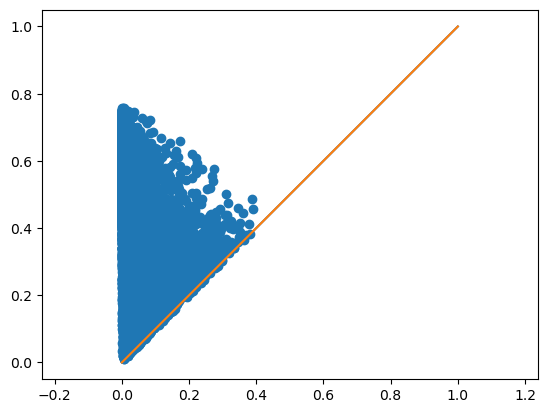

In [54]:
# plt.hist(max_softmax_single_class, bins=100)
plt.scatter(x=second_max_softmax, y=quantiles_single_class)
plt.plot([[0, 0], [1, 1]])

plt.axis("equal")

In [55]:
sorted_index = np.argsort(quantiles_single_class)

In [56]:
sorted_max_softmax = max_softmax_single_class[sorted_index]
sorted_quantiles = np.array(quantiles_single_class)[sorted_index]

In [57]:
sorted_quantiles[0]

0.008969919840828178

In [58]:
np.unique((max_softmax_single_class >= np.array(quantiles_single_class)[:, np.newaxis]).sum(axis=1))

array([ 8564,  8590,  8686, ..., 12457, 12458, 12459])

In [59]:
np.unique(y_pss['crf_score'][:, :, 0].sum(axis=1), return_counts=True)

(array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
          11,   12,   13,   14,   16,   17,   18,   19,   25,   42,   45,
          56, 1000]),
 array([  493, 12459,   807,   204,    71,    30,    12,    11,     6,
            6,     4,     2,     6,     2,     1,     1,     1,     1,
            2,     1,     1,     1,     1,  2544]))

Quantile value for CRF_score is : 1.725


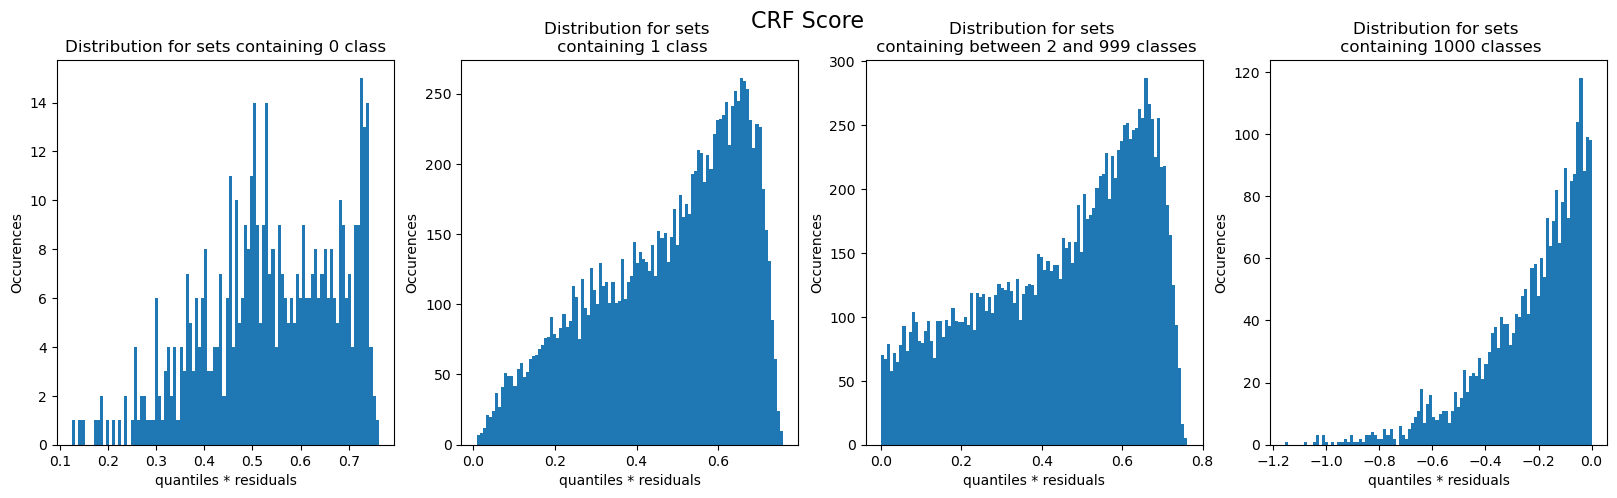

In [60]:
size_ps_1000_index = np.where(y_pss['crf_score'][:, :, 0].sum(axis=1) == 1000)[0]
size_ps_1_index = np.where(y_pss['crf_score'][:, :, 0].sum(axis=1) == 1)[0]
size_ps_0_index = np.where(y_pss['crf_score'][:, :, 0].sum(axis=1) == 0)[0]
size_ps_2_index = np.where(y_pss['crf_score'][:, :, 0].sum(axis=1) >= 2)[0]
size_ps_2_index = np.where(y_pss['crf_score'][:, :, 0].sum(axis=1) <= 999)[0]

softmax_1_index = []

quantiles_1000_ps, quantiles_1_ps, quantiles_0_ps, quantiles_2_ps = [], [], [], []
for index in size_ps_1000_index:
    quantiles_1000_ps.append(1 - quantiles['crf_score'][:, :, 0][index][0])
for index in size_ps_1_index:
    quantiles_1_ps.append(1 - quantiles['crf_score'][:, :, 0][index][0])
for index in size_ps_0_index:
    quantiles_0_ps.append(1 - quantiles['crf_score'][:, :, 0][index][0])
for index in size_ps_2_index:
    quantiles_2_ps.append(1- quantiles['crf_score'][:, :, 0][index][0])

n = cal_conformity_scores['crf_score'].shape[0]
quantile = np.quantile(np.squeeze(cal_conformity_scores['crf_score']), ((n + 1) * (1 - 0.1)) / n)
print(f'Quantile value for CRF_score is : {quantile:.3f}')

fig, axs = plt.subplots(1, 4, figsize=(5*4, 5))
fig.suptitle("CRF Score", fontsize=16)
axs[0].hist(quantiles_0_ps, bins=100)
axs[0].set_xlabel("quantiles * residuals")
axs[0].set_ylabel("Occurences")
axs[0].set_title("Distribution for sets containing 0 class")
axs[1].hist(quantiles_1_ps, bins=100)
axs[1].set_xlabel("quantiles * residuals")
axs[1].set_ylabel("Occurences")
axs[1].set_title("Distribution for sets \n containing 1 class")
axs[2].hist(quantiles_2_ps, bins=100)
axs[2].set_xlabel("quantiles * residuals")
axs[2].set_ylabel("Occurences")
axs[2].set_title("Distribution for sets \n containing between 2 and 999 classes")
axs[3].hist(quantiles_1000_ps, bins=100)
axs[3].set_xlabel("quantiles * residuals")
axs[3].set_ylabel("Occurences")
axs[3].set_title("Distribution for sets \n containing 1000 classes")
plt.show()

# Conditional Coverage Metrics

In [61]:
for method_name, _ in method_params.items():
    print(f'Method: {method_name}')
    method_ssc = classification_ssc(test_dataset[1], y_pss[method_name][:, :, 0])
    filtered_ssc = method_ssc[method_ssc != 0.00]
    nan_indices = np.isnan(filtered_ssc)
    filtered_ssc = filtered_ssc[~nan_indices]
    min_ssc = min(filtered_ssc)
    max_ssc = max(filtered_ssc)
    print(f'Min SSC = {min_ssc:.2f} & Max SSC = {max_ssc:.2f}')
    print("=" * 50)

Method: score
Min SSC = 0.79 & Max SSC = 0.93
Method: cumulated_score
Min SSC = 0.80 & Max SSC = 1.00
Method: raps
Min SSC = 0.54 & Max SSC = 0.97
Method: crf_score
Min SSC = 0.50 & Max SSC = 1.00
Method: crf_aps
Min SSC = 0.67 & Max SSC = 1.00


# Estimating the prediction sets

In [62]:
def count_null_set(y):
    count = 0
    for pred in y[:, :]:
        if np.sum(pred) == 0:
            count += 1
    return count

In [63]:
nulls, coverages, accuracies, median_sizes, mean_sizes, variances = {}, {}, {}, {}, {}, {}

for method_name, (method, include_last_label) in method_params.items():
    accuracies[method_name] = accuracy_score(y_test_set, y_preds[method_name])
    nulls[method_name] = [
        count_null_set(y_pss[method_name][:, :, i])  for i, _ in enumerate(alphas)
    ]
    coverages[method_name] = [
        classification_coverage_score(
            y_test_set, y_pss[method_name][:, :, i]
        ) for i, _ in enumerate(alphas)
    ]
    median_sizes[method_name] = [
        np.median(y_pss[method_name][:, :, i].sum(axis=1), axis=0) for i, _ in enumerate(alphas)
    ]
    mean_sizes[method_name] = [
        y_pss[method_name][:, :, i].sum(axis=1).mean() for i, _ in enumerate(alphas)
    ]
    variances[method_name] = [
        y_pss[method_name][:, :, i].sum(axis=1).std() for i, _ in enumerate(alphas)
    ]

In [64]:
nulls_90 = {k: int(v[0]) for k, v in nulls.items()}
coverages_90 = {k: v[0] for k, v in coverages.items()}
mean_sizes_90 = {k: v[0] for k, v in mean_sizes.items()}
median_sizes_90 = {k: v[0] for k, v in median_sizes.items()}
variances_90 = {k: v[0] for k, v in variances.items()}
names = ["Number of null sets", "Coverages", "Mean prediction set sizes", "Median prediction set sizes", "Standard deviation of PS sizes"]

In [65]:
summary_df = pd.DataFrame([nulls_90, coverages_90, mean_sizes_90, median_sizes_90, variances_90]).round(3)
summary_df.insert(0, '', names)
summary_df

score  cumulated_score   raps  crf_score  \
0             Number of null sets  26.000            0.000  0.000    493.000   
1                       Coverages   0.898            0.958  0.934      0.901   
2       Mean prediction set sizes   1.329           27.429  2.616    153.585   
3     Median prediction set sizes   1.000            1.000  3.000      1.000   
4  Standard deviation of PS sizes   0.615           68.677  0.783    359.236   

   crf_aps  
0    0.000  
1    0.945  
2  105.880  
3    4.000  
4  177.836

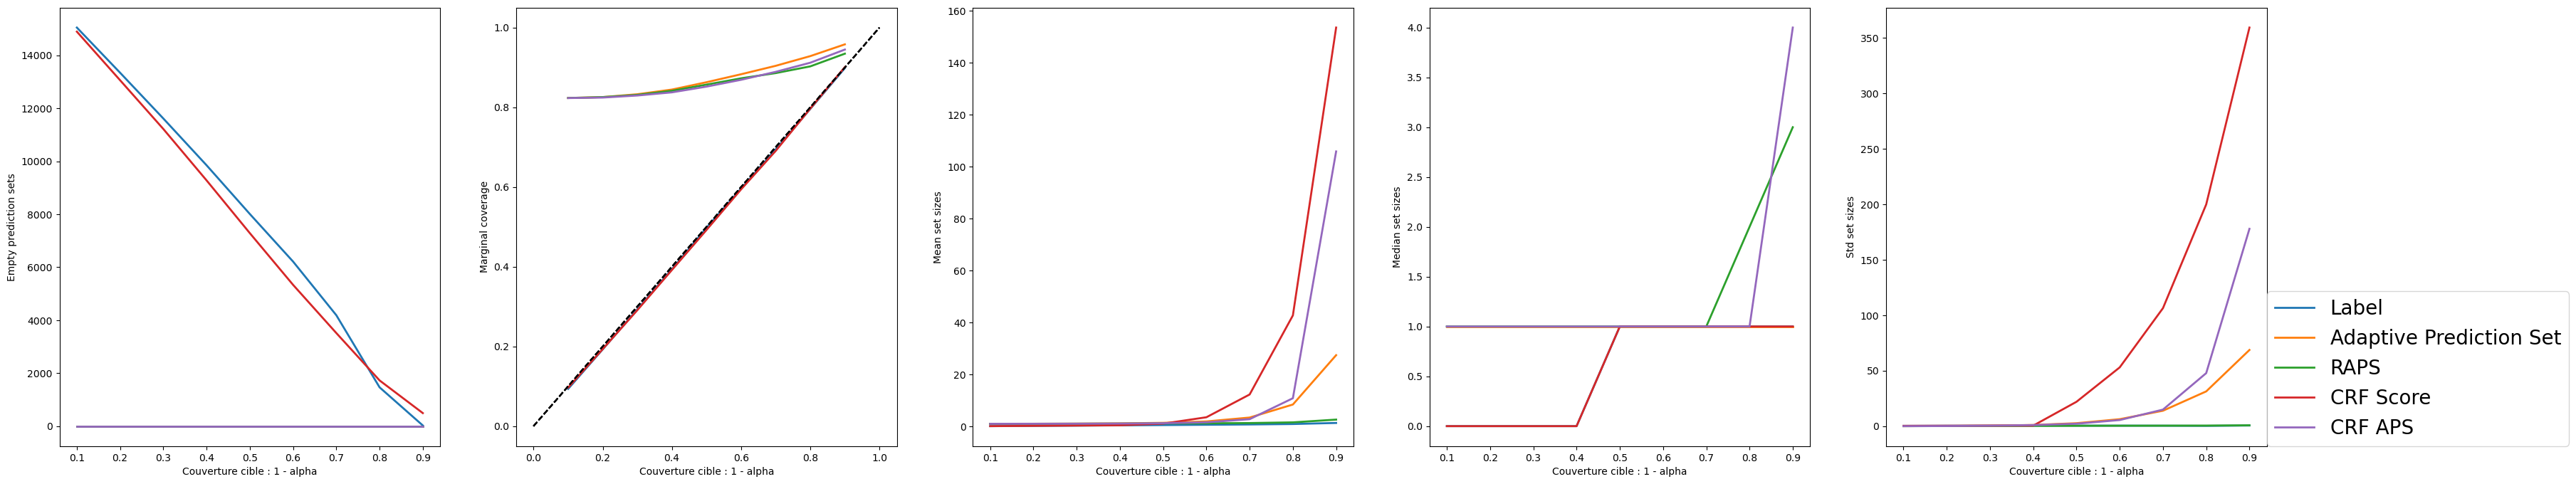

In [66]:
vars_y = [nulls, coverages, mean_sizes, median_sizes, variances]
label_mapping = {
    # "naive": "Naive",
    "score": "Label",
    "cumulated_score": "Adaptive Prediction Set",
    "raps": "RAPS",
    "crf_score": "CRF Score",
    "crf_aps": "CRF APS"
}
labels_y = ["Empty prediction sets", "Marginal coverage", "Mean set sizes", "Median set sizes", "Std set sizes"]
fig, axs = plt.subplots(1, len(vars_y), figsize=(8*len(vars_y), 8))
for i, var in enumerate(vars_y):
    for name, (method, include_last_label) in method_params.items():
        axs[i].plot(1 - alphas, var[name], label=label_mapping[name], linewidth=2)
        if i == 1:
            axs[i].plot([0, 1], [0, 1], ls="--", color="k")
    axs[i].set_xlabel("Couverture cible : 1 - alpha")
    axs[i].set_ylabel(labels_y[i])
    if i == len(vars_y) - 1:
        axs[i].legend(fontsize=20, loc=[1, 0])

# CRF-APS Quantile

In [67]:
n = cal_conformity_scores['crf_aps'].shape[0]
quantile = np.quantile(np.squeeze(cal_conformity_scores['crf_aps']), ((n + 1) * (1 - 0.1)) / n)
print(f'Quantile value for CRF_APS is : {quantile:.3f}')

Quantile value for CRF_APS is : 1.055


In [145]:
sizes = y_pss['crf_aps'][:, :, 0].sum(axis=1)
unique_sizes = np.unique(sizes)
size_stratified_accuracy = np.zeros(len(unique_sizes))
for i, size in enumerate(unique_sizes):
    size_index = list(np.where(sizes == size)[0])
    size_accuracy, size_y_true, size_y_pred = [], [], []  
    for index in size_index:
        size_y_true.append(test_dataset[1][index])
        size_y_pred.append(y_preds['crf_aps'][index])
        size_accuracy = accuracy_score(size_y_pred, size_y_true)
    size_stratified_accuracy[i] = size_accuracy

Text(0, 0.5, 'Accuracy')

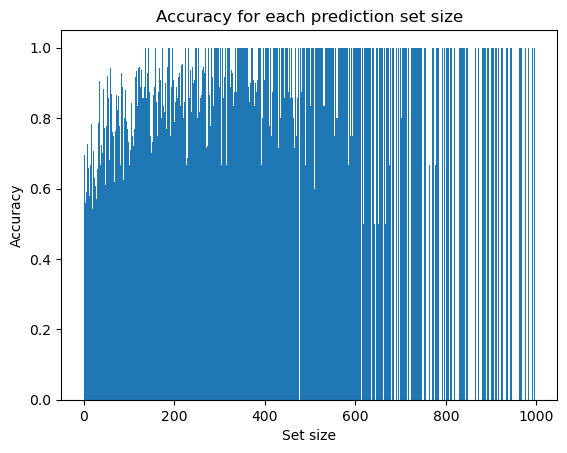

In [146]:
plt.bar(unique_sizes, size_stratified_accuracy, width=1)
plt.title("Accuracy for each prediction set size")
plt.xlabel("Set size")
plt.ylabel("Accuracy")

In [158]:
crf_aps_ssc = classification_ssc(test_dataset[1], y_pss['crf_aps'][:, :, 0])
filtered_ssc = crf_aps_ssc#[crf_aps_ssc != 0.00]
nan_indices = np.isnan(filtered_ssc)
filtered_ssc = filtered_ssc[~nan_indices]

Text(0, 0.5, 'Accuracy')

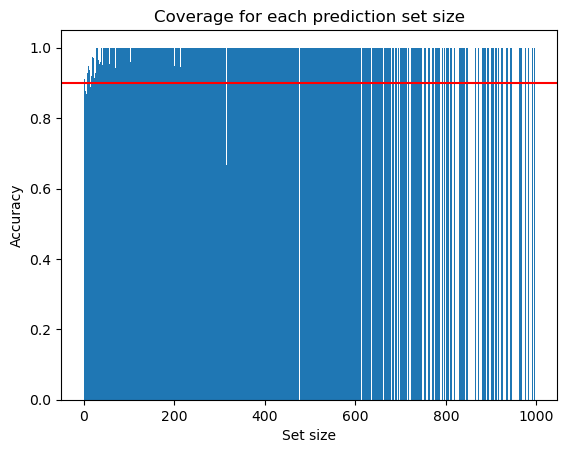

In [164]:
plt.bar(unique_sizes, filtered_ssc, width=1)
plt.axhline(y=0.9, color='r')
plt.title("Coverage for each prediction set size")
plt.xlabel("Set size")
plt.ylabel("Accuracy")

# Distribution of non-conformity scores

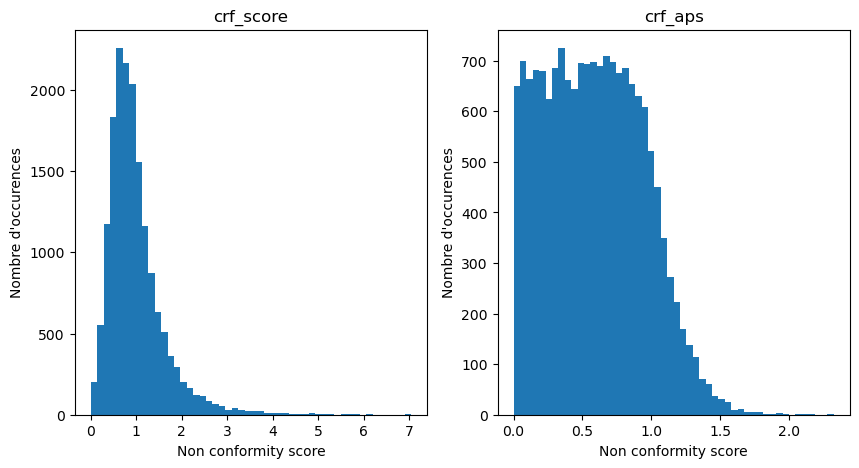

In [369]:
fig, axs = plt.subplots(1, len(method_params), figsize=(5*len(method_params), 5))
for i, (method, scores) in enumerate(cal_conformity_scores.items()):
    axs[i].hist(scores, bins=50, label=method)
    axs[i].set_xlabel("Non conformity score")
    axs[i].set_ylabel("Nombre d'occurences")
    axs[i].set_title(method)

# Distribution of predicted residuals

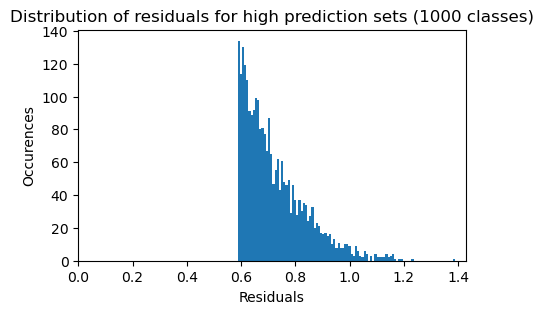

In [373]:
high_size_ps_index = np.where(y_pss['crf_score'][:, :, 0].sum(axis=1) == 1000)[0]
high_size_ps_residuals = []
for index in high_size_ps_index:
    high_size_ps_residuals.append(y_test_res_score_pred[index])

fig = plt.figure(figsize=(5, 3))
plt.hist(high_size_ps_residuals, bins=100)
plt.title("Distribution of residuals for high prediction sets (1000 classes)")
plt.xlabel("Residuals")
plt.xlim(0)
plt.ylabel("Occurences")
plt.show()

Text(0.5, 1.0, 'CRF APS')

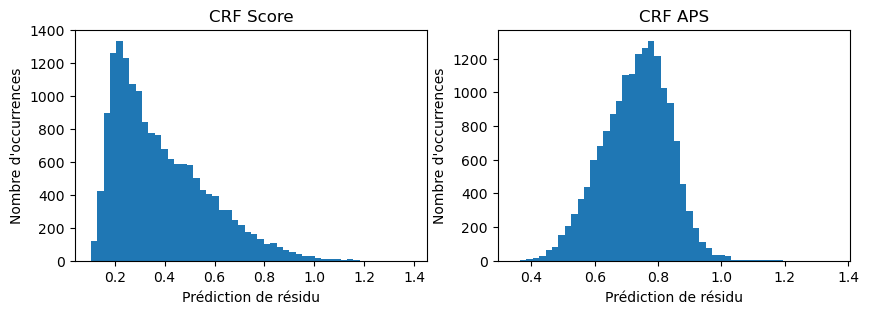

In [374]:
crf_methods = ['crf_score', 'crf_aps']

fig, axs = plt.subplots(1, len(crf_methods), figsize=(5*len(crf_methods), 3))
axs[0].hist(y_test_res_score_pred, bins=50)
axs[0].set_xlabel("Prédiction de résidu")
axs[0].set_ylabel("Nombre d'occurrences")
axs[0].set_title("CRF Score")

axs[1].hist(y_test_res_aps_pred, bins=50)
axs[1].set_xlabel("Prédiction de résidu")
axs[1].set_ylabel("Nombre d'occurrences")
axs[1].set_title("CRF APS")

Text(0.5, 1.0, 'Distribution des résidus prédis \n pour des petits prédictions sets (< 999)')

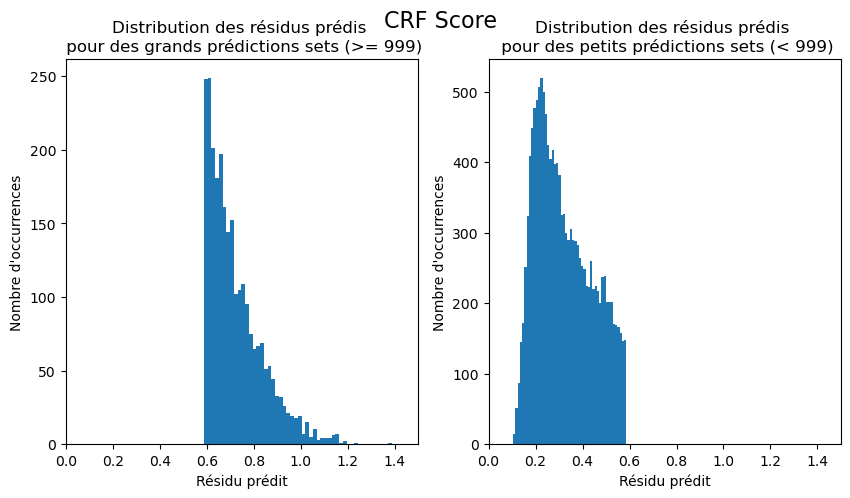

In [375]:
high_size_ps_index = np.where(y_pss['crf_score'][:, :, 0].sum(axis=1) >= 999)[0]
low_size_ps_index = np.where(y_pss['crf_score'][:, :, 0].sum(axis=1) < 999)[0]

high_size_ps_residuals = []
low_size_ps_residuals = []
for index in high_size_ps_index:
    high_size_ps_residuals.append(y_test_res_score_pred[index])
for index in low_size_ps_index:
    low_size_ps_residuals.append(y_test_res_score_pred[index])

fig, axs = plt.subplots(1, len(crf_methods), figsize=(5*len(crf_methods), 5))
fig.suptitle("CRF Score", fontsize=16)
axs[0].hist(high_size_ps_residuals, bins=50)
axs[0].set_xlim(0, 1.5)
axs[0].set_xlabel("Résidu prédit")
axs[0].set_ylabel("Nombre d'occurrences")
axs[0].set_title("Distribution des résidus prédis \n pour des grands prédictions sets (>= 999)")

axs[1].hist(low_size_ps_residuals, bins=50)
axs[1].set_xlim(0, 1.5)
axs[1].set_xlabel("Résidu prédit")
axs[1].set_ylabel("Nombre d'occurrences")
axs[1].set_title("Distribution des résidus prédis \n pour des petits prédictions sets (< 999)")

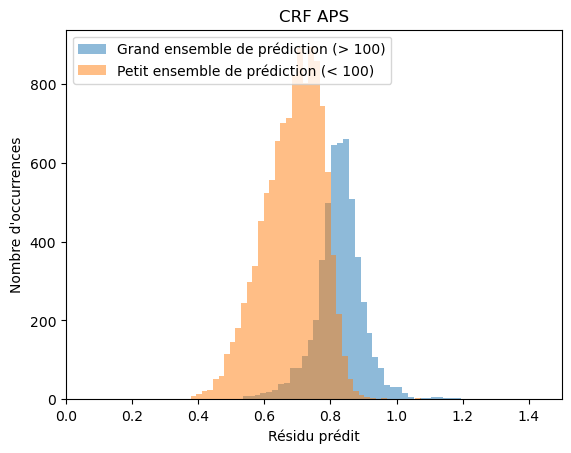

In [376]:
high_size_ps_index = np.where(y_pss['crf_aps'][:, :, 0].sum(axis=1) >= 100)[0]
low_size_ps_index = np.where(y_pss['crf_aps'][:, :, 0].sum(axis=1) < 100)[0]

high_size_ps_residuals = []
low_size_ps_residuals = []
for index in high_size_ps_index:
    high_size_ps_residuals.append(y_test_res_aps_pred[index])
for index in low_size_ps_index:
    low_size_ps_residuals.append(y_test_res_aps_pred[index])

plt.hist(high_size_ps_residuals, bins=50, alpha=0.5, label="Grand ensemble de prédiction (> 100)")
plt.hist(low_size_ps_residuals, bins=50, alpha=0.5, label="Petit ensemble de prédiction (< 100)")
plt.xlim(0, 1.5)
plt.xlabel("Résidu prédit")
plt.ylabel("Nombre d'occurrences")
plt.title("CRF APS")
plt.legend(loc='upper left')

# Distribution of prediction set sizes

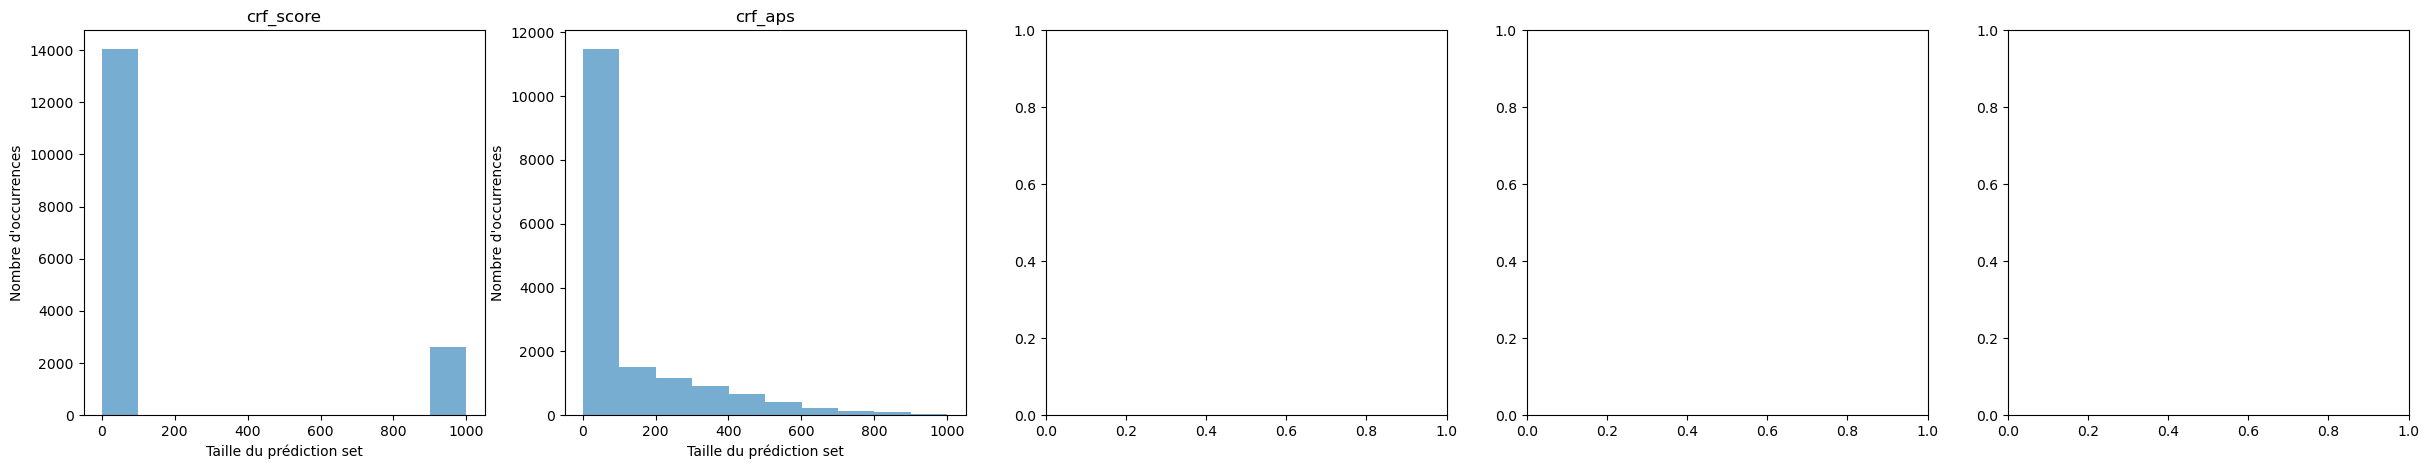

In [377]:
fig, axs = plt.subplots(1, len(label_mapping), figsize=(6*len(label_mapping), 5))
for i, (method, predictions) in enumerate(y_pss.items()):
    pss = predictions[:, :, 0].sum(axis=1)
    axs[i].hist(pss, bins=10, alpha=0.6, label=method)

    axs[i].set_xlabel("Taille du prédiction set")
    axs[i].set_ylabel("Nombre d'occurrences")
    axs[i].set_title(method)

# Vizualisation of images with a prediction set size of a 1000

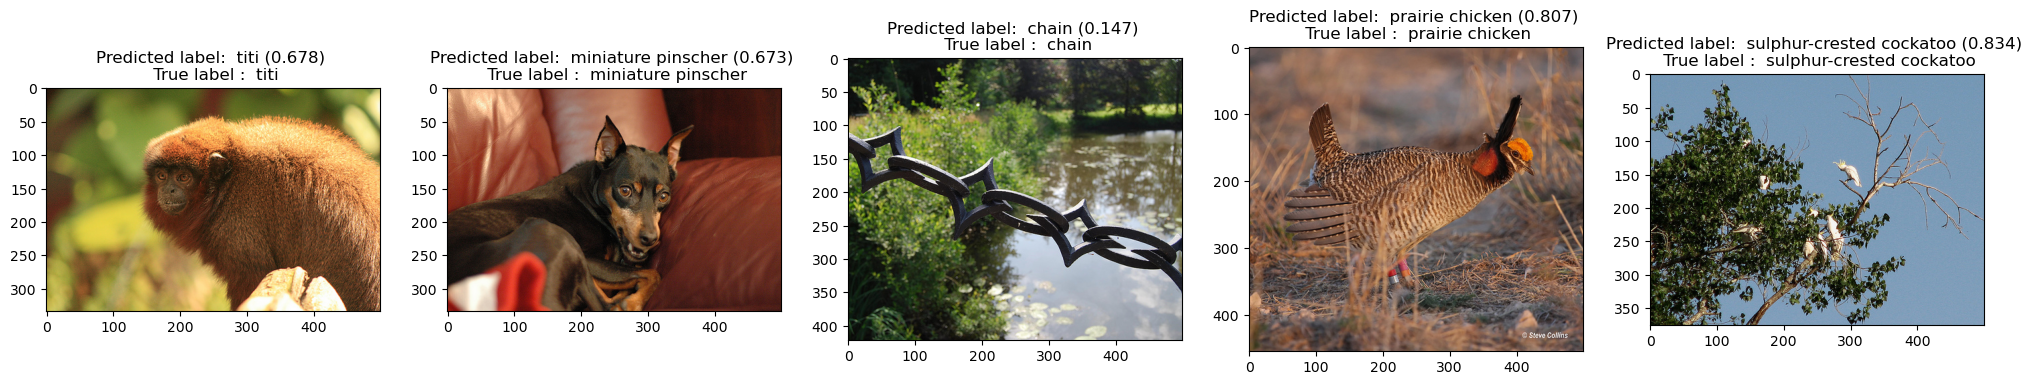

In [379]:
high_size_ps_indices_to_plot = random.sample(high_size_ps_index.tolist(), k=n_cols)

n_rows = 1
n_cols = len(high_size_ps_indices_to_plot)
plot_size = 5

f, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * plot_size, n_rows * plot_size))

for i, index in enumerate(high_size_ps_indices_to_plot):
    y_true_label_index_key = test_dataset[1][index]
    y_true_label_key = labels_keys[y_true_label_index_key]
    y_true_label = labels[y_true_label_key]

    y_pred_label_index_key = y_preds['crf_score'][index]
    y_pred_label_index = labels_keys[y_pred_label_index_key]
    y_pred_label = labels[y_pred_label_index]

    image_name = test_dataset[0].files_name.iloc[index]
    image = cv2.imread(
        os.path.join(
            PATH_IMAGES,
            image_name
        )
    )
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[i].imshow(image)
    
    predicted_proba = np.max(test_dataset[0]['softmax'].values[index])
    
    title = f"Predicted label: {y_pred_label.split(',')[0]} ({predicted_proba:.3f}) \n True label : {y_true_label.split(',')[0]}"
    ax[i].set_title(title)

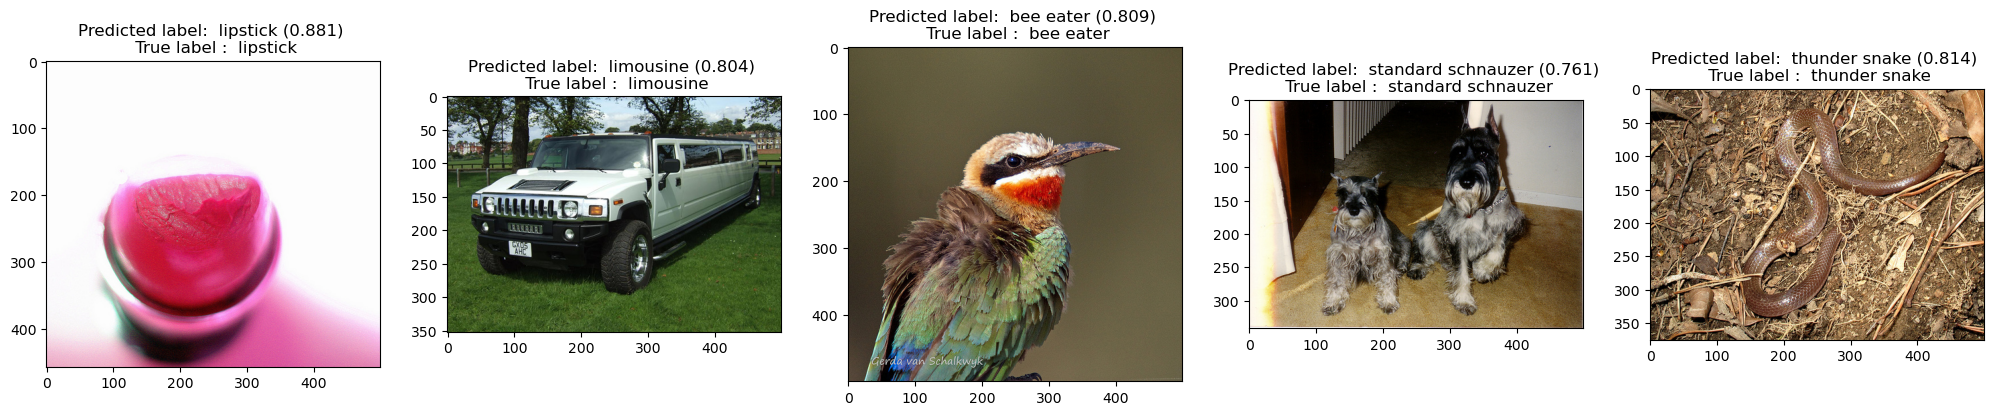

In [775]:
low_size_ps_index = np.where(y_pss['crf_score'][:, :, 0].sum(axis=1) == 1)[0]
low_size_ps_indices_to_plot = random.sample(low_size_ps_index.tolist(), k=n_cols)

n_rows = 1
n_cols = len(high_size_ps_indices_to_plot)
plot_size = 5

f, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * plot_size, n_rows * plot_size))

for i, index in enumerate(low_size_ps_indices_to_plot):
    y_true_label_index_key = test_dataset[1][index]
    y_true_label_key = labels_keys[y_true_label_index_key]
    y_true_label = labels[y_true_label_key]

    y_pred_label_index_key = y_preds['crf_score'][index]
    y_pred_label_index = labels_keys[y_pred_label_index_key]
    y_pred_label = labels[y_pred_label_index]

    image_name = test_dataset[0].files_name.iloc[index]
    image = cv2.imread(
        os.path.join(
            PATH_IMAGES,
            image_name
        )
    )
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[i].imshow(image)
    
    predicted_proba = np.max(test_dataset[0]['softmax'].values[index])
    
    title = f"Predicted label: {y_pred_label.split(',')[0]} ({predicted_proba:.3f}) \n True label : {y_true_label.split(',')[0]}"
    ax[i].set_title(title)

In [780]:
high_ps_y_true, high_ps_y_pred = [], []
for index in high_size_ps_index:
    y_pred_label_index_key = y_preds['crf_score'][index]
    y_true_label_index_key = test_dataset[1][index]
    high_ps_y_pred.append(y_pred_label_index_key)
    high_ps_y_true.append(y_true_label_index_key)

low_ps_y_true, low_ps_y_pred = [], []
for index in low_size_ps_index:
    y_pred_label_index_key = y_preds['crf_score'][index]
    y_true_label_index_key = test_dataset[1][index]
    low_ps_y_pred.append(y_pred_label_index_key)
    low_ps_y_true.append(y_true_label_index_key)

high_size_ps_accuracy = accuracy_score(y_true=high_ps_y_true, y_pred=high_ps_y_pred)
low_size_ps_accuracy = accuracy_score(y_true=low_ps_y_true, y_pred=low_ps_y_pred)
print(f'Model accuracy on images with high size prediction sets : {high_size_ps_accuracy:.2f}')
print(f'Model accuracy on images with low size prediction sets : {low_size_ps_accuracy:.2f}')

Model accuracy on images with high size prediction sets : 0.50
Model accuracy on images with low size prediction sets : 0.92
